In [18]:
#%%  
import numpyro as npy
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist

import numpy as np
import jax.numpy as jnp
import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import matplotlib.pyplot as plt

import timeit

In [19]:
nL = np.genfromtxt('../graphs/ER-10-05.csv', delimiter=',')
L = jnp.array(nL)

In [20]:
def NetworkFKPP(u, t, p):
    k, a, L = p
    dudt = -k * jnp.matmul(L, u) + a * u * (1 - u)
    return dudt

In [21]:
u = np.zeros(10)
u[4] = 0.1
u0 = jnp.array(u)

p = [0.5,1.5,L]

t = jnp.arange(0,10,1.0)

sol = odeint(NetworkFKPP, u0, t, p)

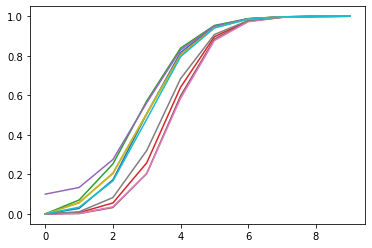

In [22]:
plt.plot(t, sol)
plt.show()

In [23]:
def model(data=sol, f=NetworkFKPP, t=t, u0=u0, L=L):

    sigma = npy.sample("σ", dist.InverseGamma(2., 3.))

    k = npy.sample("k", dist.TruncatedNormal(0.0,1.0,3.0))
    a = npy.sample("a", dist.TruncatedNormal(0.0,1.0,3.0))

    predictions = odeint(f, u0, t, [k, a, L])

    npy.sample("obs", dist.Normal(predictions, sigma), obs=data)

In [26]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
rng_key = PRNGKey(0)

start_time = timeit.default_timer()

mcmc.run(rng_key, data=sol, f=NetworkFKPP, t=t, u0=u0, L=L)

print(timeit.default_timer() - start_time)

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:12<00:00, 156.23it/s, 3 steps of size 5.65e-01. acc. prob=0.93]


15.950538593999227

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.50      0.01      1.50      1.48      1.52    718.81      1.00
         k      0.50      0.03      0.50      0.46      0.54    658.55      1.00
         σ      0.03      0.00      0.03      0.03      0.04    657.27      1.00

Number of divergences: 0
